In [48]:
import cv2 
import pandas as pd                
import numpy as np         
import os            

import matplotlib.pyplot as plt
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense , Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.image_data_format()
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

from keras.utils.np_utils import to_categorical
from keras.callbacks import Callback

In [2]:
DIR_TRAIN = "C:/NEW_ML/chest_xray/train/";
DIR_TEST = "C:/NEW_ML/chest_xray/test/";
DIR_VALI = "C:/NEW_ML/chest_xray/val/";


# function to load and resize images

def grabber(DIR):
    data = []
    label = []
    for folder in os.listdir(DIR):
        if (folder=='NORMAL'):
            for file_name in os.listdir(DIR+str(folder)+"/"):
                img = cv2.imread(DIR+str(folder)+"/"+file_name,cv2.IMREAD_GRAYSCALE);
                if (img is not None): 
                    new_img = cv2.resize(img, (200,200));
                    new_img =new_img/255
                    data.append(new_img)
                    label.append(0);
        elif (folder=='PNEUMONIA'):
            for file_name in os.listdir(DIR+str(folder)+"/"):
                img = cv2.imread(DIR+str(folder)+"/"+file_name,cv2.IMREAD_GRAYSCALE);
                if (img is not None): 
                    new_img = cv2.resize(img, (200,200));
                    new_img =new_img/255
                    data.append(new_img)
                    label.append(1)
    return data, label;

train_data, train_label = grabber(DIR_TRAIN)

test_data, test_label = grabber(DIR_TEST)

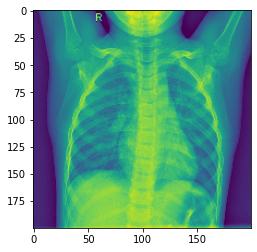

In [3]:
plt.figure()
plt.imshow(train_data[0])
plt.rcParams["figure.figsize"] = (15,2)

In [4]:
train_data= np.asarray(train_data)


test_data= np.asarray(test_data)

train_data=train_data.reshape(train_data.shape[0],200,200,1)
test_data=test_data.reshape(test_data.shape[0],200,200,1)

print(test_data.shape)

(624, 200, 200, 1)


In [5]:
train_label = to_categorical(train_label, 2)
test_label = to_categorical(test_label, 2)

In [45]:
class CustomCallback(Callback):
    
    def __init__(self, validation_data=[]): 
        self.run = 0;
        self.prev_acc = int(0)
        self.x = validation_data[0]
        self.y = validation_data[1]
        
    def on_train_begin(self, logs=None):
        tf.keras.backend.set_value(self.model.optimizer.lr,0.0005)
    
    def on_epoch_end(self, epoch, logs=None):
        self.run = self.run+1
        loss, acc = self.model.evaluate(self.x, self.y, verbose=0)
        
        # Uncomment to update the saved model
        '''
        if self.prev_acc<acc:
            self.model.save("my_model")
        '''
        self.prev_acc = acc
        #print(acc)
callbacks = CustomCallback(validation_data = [test_data , test_label]);

In [46]:


model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(200,200,1)))
model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(200,200,1)))
model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='sigmoid'))
model.add(Dense(2 , activation='sigmoid'))

model.compile(loss='binary_crossentropy',
                  optimizer=RMSprop(lr=0.0005),
                  metrics=['accuracy'])

print(model.summary())

history = model.fit(train_data, train_label, validation_data = (test_data , test_label) ,callbacks=[callbacks] ,
          epochs=6)


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_168 (Conv2D)          (None, 200, 200, 16)      160       
_________________________________________________________________
conv2d_169 (Conv2D)          (None, 200, 200, 16)      2320      
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_170 (Conv2D)          (None, 100, 100, 16)      2320      
_________________________________________________________________
conv2d_171 (Conv2D)          (None, 100, 100, 16)      2320      
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_172 (Conv2D)          (None, 50, 50, 32)      

In [49]:
loaded = load_model("my_model")

In [50]:
loss, acc = loaded.evaluate(test_data, test_label, verbose=0)

In [51]:
acc

0.8341346383094788

In [52]:
from sklearn.metrics import confusion_matrix
pred = loaded.predict(test_data)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_label,axis = 1)



[[140  94]
 [  9 381]]


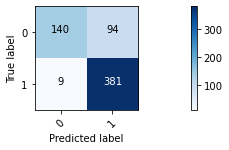

In [57]:
cmap=plt.cm.Blues
cm = confusion_matrix(y_true, pred)

plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, [0,1], rotation=45)
plt.yticks(tick_marks, [0,1])


print(cm)

from itertools import product

thresh = cm.max() / 2.
for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [59]:
381/(381+9)

0.9769230769230769

In [63]:
vali_data, vali_label = grabber(DIR_VALI)

In [64]:
vali_data= np.asarray(vali_data)

vali_data=vali_data.reshape(vali_data.shape[0],200,200,1)


In [65]:
vali_label = to_categorical(vali_label, 2)

In [66]:
loss, acc = loaded.evaluate(vali_data, vali_label, verbose=0)
acc

0.875

In [1]:
train_data

NameError: name 'train_data' is not defined